In [1]:
import os, warnings, datetime
warnings.filterwarnings(action='ignore')
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, RidgeClassifierCV, RidgeCV, LassoCV, ElasticNetCV
from sklearn import tree, svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import glob

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import roc_curve

num_CV = 5  # number of crossvalidation #
n_splits = 5
repeat = 100
max_iter = 100000 # max iteration for SVM #
alphas = np.logspace(-4, 4, 17)

In [3]:
df = pd.read_csv("final_data_histogram.csv")

training_df = df.loc[df['Outside'] == 0]
test_df = df.loc[df['Outside'] == 1]

X_train = training_df.iloc[:, 5:]
y_train = training_df.iloc[:, 1 ]
X_test = test_df.iloc[:, 5:]
y_test = test_df.iloc[:, 1 ]

X_train

,ADC_firstorder_Mean,ADC_firstorder_10Percentile,ADC_firstorder_50Percentile,ADC_firstorder_90Percentile,ADC_firstorder_Minimum,ADC_firstorder_Maximum,ADC_firstorder_Skewness,ADC_firstorder_Kurtosis,ADC_firstorder_Variance
0,912.926311,418.962299,926.651179,1342.535164,1.660526,2150.294500,-0.242263,3.093541,123068.00190
1,1259.924843,810.438685,1232.813533,1765.118740,22.594957,2864.934460,0.162137,3.096423,144156.13010
2,407.438868,164.302035,406.426926,647.377832,2.896889,1080.398872,0.105859,2.523027,34340.37280
3,761.409342,574.516331,732.182244,1031.487878,19.883797,1830.499889,0.401662,4.797599,41086.06261
4,740.411653,197.295309,700.257559,1238.867907,1.555414,2540.712971,0.974225,4.518267,185507.54000
...,...,...,...,...,...,...,...,...,...
145,528.355702,205.094276,522.874261,825.036335,0.929957,1620.407401,0.405490,3.750324,58450.62179
147,698.050058,313.512649,722.798362,1032.193961,-168.408966,1445.339001,-0.509566,3.139474,79154.72569
149,597.122336,393.718786,576.156372,843.067679,24.500896,1447.030483,0.208496,3.120053,34071.03938
152,782.097625,434.489460,775.541584,1132.587607,-153.439064,1562.114076,-0.317098,3.249330,79470.20273


In [4]:
dataset = 'ADChistogram'
oversamples = ['original', 'ros', 'smote', 'adasyn', 'bsmote', 'svmsmote'] 
methods = ['linear', 'logistic', 'ridge', 'lasso', 'elastic', 'decisiontree', 'randomforest', 'adaboost', 'svm-linear', 'svm-poly', 'svm-rbf', 'fullyconnected']
col_names = []
count = 0
for o in oversamples:
    for m in methods:
        col_names.append("{}-{}".format(o, m))
df_train_result = pd.DataFrame([], columns = col_names)
df_test_result = pd.DataFrame([], columns = col_names)
pbar = tqdm(total=repeat*n_splits*len(oversamples)*len(methods))
for seed in range(repeat):
    col_train_values = []
    col_test_values = []
    ros = RandomOverSampler(sampling_strategy='auto', random_state=seed)
    sm = SMOTE(sampling_strategy='auto', random_state=seed)
    adas = ADASYN(sampling_strategy='auto', random_state=seed)
    bsm = BorderlineSMOTE(sampling_strategy='auto', random_state=seed)
    ksm = KMeansSMOTE(sampling_strategy='auto', random_state=seed)
    ssm = SVMSMOTE(sampling_strategy='auto', random_state=seed)
    for _, oversample in enumerate(oversamples):
        if oversample == 'original':
            X_sampled, y_sampled = X_train, y_train
        elif oversample == 'ros':
            X_sampled, y_sampled = ros.fit_resample(X_train,y_train)
        elif oversample == 'smote':
            X_sampled, y_sampled = sm.fit_resample(X_train,y_train)
        elif oversample == 'adasyn':
            X_sampled, y_sampled = adas.fit_resample(X_train,y_train)
        elif oversample == 'bsmote':
            X_sampled, y_sampled = bsm.fit_resample(X_train,y_train)
        elif oversample == 'ksmote':
            X_sampled, y_sampled = ksm.fit_resample(X_train,y_train)
        elif oversample == 'svmsmote':
            X_sampled, y_sampled = ssm.fit_resample(X_train,y_train)
        for _, method in enumerate(methods):
            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
            AUC_trains = 0
            AUC_tests = 0
            for _, (train, val) in enumerate(cv.split(X_sampled, y_sampled)):
                if method == 'fullyconnected':
                    sc = StandardScaler()
                    X_stand = sc.fit_transform(X_sampled)
                    X_stand_test = sc.transform(X_test)
                    classifier = Sequential()
                    classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_sampled.shape[1]))
                    classifier.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
                    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
                    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
                    classifier.fit(X_stand[train], y_sampled.to_numpy()[train], batch_size = 10, epochs = 2, verbose = 0)
                    preds_train = classifier.predict(X_stand)
                    preds_test = classifier.predict(X_stand_test)
                else:
                    if method == 'linear':
                        classifier = LinearRegression()
                    elif method == 'logistic':
                        classifier = LogisticRegressionCV(cv = num_CV, random_state=seed)
                    elif method == 'ridge':
                        classifier = RidgeCV(alphas = alphas, cv = num_CV)
                    elif method =='lasso':
                        classifier = LassoCV(alphas = alphas, cv = num_CV, random_state=seed)
                    elif method =='elastic':
                        classifier = ElasticNetCV(alphas=alphas, l1_ratio=0.5, cv = num_CV, random_state=seed)
                    elif method == 'decisiontree':
                        classifier = tree.DecisionTreeClassifier()
                    elif method == 'randomforest':
                        classifier = RandomForestClassifier(max_depth=4, random_state=seed)
                    elif method == 'adaboost':
                        classifier = AdaBoostClassifier(n_estimators=1000, random_state=seed)
                    elif method == 'svm-linear':
                        classifier = svm.SVC(kernel='linear', max_iter = max_iter)
                    elif method == 'svm-poly':
                        classifier = svm.SVC(kernel='poly', max_iter = max_iter)
                    elif method == 'svm-rbf':
                        classifier = svm.SVC(kernel='rbf', max_iter = max_iter)
                    classifier.fit(X_sampled.to_numpy()[train], y_sampled.to_numpy()[train])
                    preds_train = classifier.predict(X_sampled)
                    preds_test = classifier.predict(X_test)                        
                performance_train = roc_auc_score(y_sampled, preds_train)
                performance_test = roc_auc_score(y_test, preds_test)
                AUC_trains += performance_train
                AUC_tests += performance_test
                pbar.update(1)
            col_train_values.append(AUC_trains/n_splits)
            col_test_values.append(AUC_tests/n_splits)
    df_train_result.loc[seed] = col_train_values
    df_test_result.loc[seed] = col_test_values
df_train_result.to_excel("{}-{}-train.xlsx".format(dataset, repeat))
print("saved: ", "{}-{}-train.xlsx".format(dataset, repeat))
df_test_result.to_excel("{}-{}-validation.xlsx".format(dataset, repeat))
print("saved: ", "{}-{}-validation.xlsx".format(dataset, repeat))

  0%|          | 0/36000 [00:00<?, ?it/s]

7/7 [==============================] - 0s 1ms/step


7/7 [==============================] - 0s 1000us/step


6/6 [==============================] - 0s 899us/step


7/7 [==============================] - 0s 1ms/step


2/2 [==============================] - 0s 2ms/step


5/5 [==============================] - 0s 1ms/step


7/7 [==============================] - 0s 1ms/step


7/7 [==============================] - 0s 1ms/step


5/5 [==============================] - 0s 1ms/step


7/7 [==============================] - 0s 1ms/step


7/7 [==============================] - 0s 1ms/step


5/5 [==============================] - 0s 1ms/step


7/7 [==============================] - 0s 1ms/step


7/7 [==============================] - 0s 1ms/step


7/7 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1ms/step


7/7 [==============================] - 0s 1ms/step


7/7 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1ms/step


7/7 [==============================] - 0s 973us/step


7/7 [==============================] - 0s 993us/step


4/4 [==============================] - 0s 1ms/step


7/7 [==============================] - 0s 1ms/step


7/7 [==============================] - 0s 999us/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 3ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step


2/2 [==============================] - 0s 2ms/step
saved:  ADChistogram-100-train.xlsx
saved:  ADChistogram-100-validation.xlsx


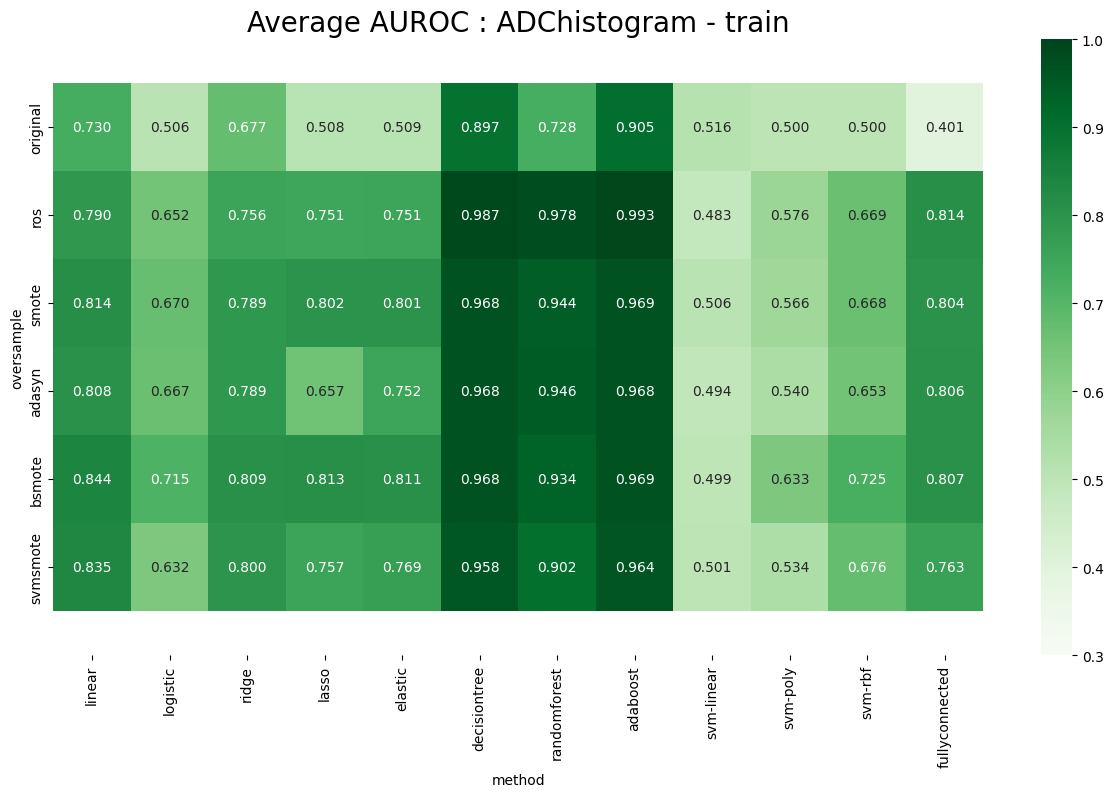

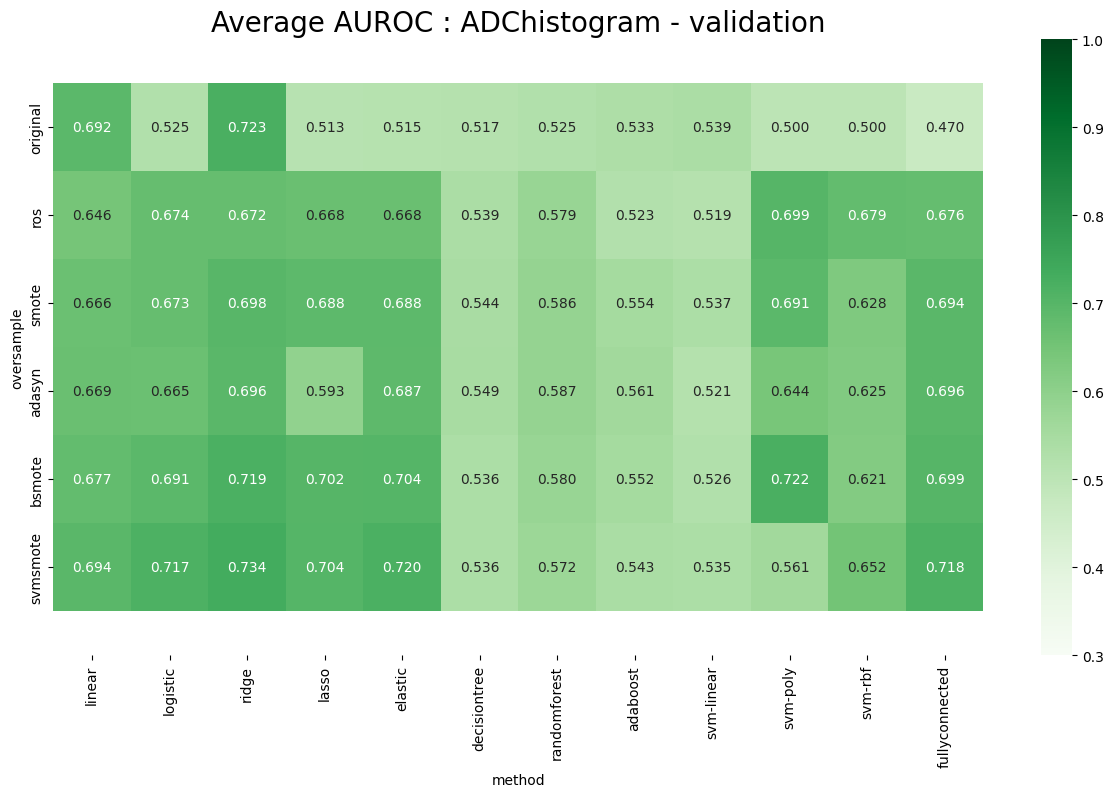

In [5]:
import seaborn as sns
plt.rcParams['figure.figsize'] = [15, 8]
subsets = ['train', 'validation']
for subset in subsets:
    df_raw = pd.read_excel('ADChistogram-{}-{}.xlsx'.format(repeat, subset))
    df_average = pd.DataFrame([],
                      index=pd.Index(oversamples, name='oversample'),
                      columns=pd.Index(methods, name='method'))
    for oversample in oversamples:
        for method in methods:
            df_average.loc[oversample, method] = df_raw["{}-{}".format(oversample, method)].mean()
    ax = sns.heatmap(df_average.astype(np.float64), annot=True, fmt=".3f", cmap="Greens", vmin=0.3, vmax=1)
    buttom, top = ax.get_ylim()
    ax.set_ylim(buttom+0.5, top-0.5)
    plt.title('Average AUROC : {} - {}'.format(dataset, subset), fontsize=20)
    plt.show()